## Project 7
In this project, you will implement the the clustering techniques that you've learned this week.

#### Step 1: Load the python libraries that you will need for this project

In [11]:
import pandas as pd 
import matplotlib.style
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.stats import pearsonr, normaltest
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist

from sklearn import cluster, metrics, preprocessing, linear_model, decomposition, datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning) 

matplotlib.style.use('ggplot') 
%matplotlib inline

#### Step 2: Examine your data

In [31]:
df_ops = pd.read_csv("assets/airport_operations.csv")
df_ops.dropna(inplace = True)
df_ops.columns = ['airport','year','dep','arr','ot_gate_dep','ot_ap_dep','ot_gate_arr','gate_dep_del','taxi_out', \
                  'taxi_out_del','ap_dep_del','in_air_del','taxi_in_del','block_del','gate_arr_del']
df_ops.head()

,airport,year,dep,arr,ot_gate_dep,ot_ap_dep,ot_gate_arr,gate_dep_del,taxi_out,taxi_out_del,ap_dep_del,in_air_del,taxi_in_del,block_del,gate_arr_del
0,ABQ,2004,53971,53818,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2005,51829,51877,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2006,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2007,53255,53611,0.8005,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,ABQ,2008,49589,49512,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


In [32]:
df_cxl = pd.read_csv("assets/airport_cancellations.csv")
df_cxl.dropna(inplace = True)
df_cxl.columns = ['airport','year','dep_cxl','arr_cxl','dep_div','arr_div']
df_cxl.head()

,airport,year,dep_cxl,arr_cxl,dep_div,arr_div
0,ABQ,2004.0,242.0,235.0,71.0,46.0
1,ABQ,2005.0,221.0,190.0,61.0,33.0
2,ABQ,2006.0,392.0,329.0,71.0,124.0
3,ABQ,2007.0,366.0,304.0,107.0,45.0
4,ABQ,2008.0,333.0,300.0,79.0,42.0


In [33]:
df_master = pd.merge(df_cxl, df_ops, how = 'left', on=['airport', 'year'])
df_master.head()

,airport,year,dep_cxl,arr_cxl,dep_div,arr_div,dep,arr,ot_gate_dep,ot_ap_dep,ot_gate_arr,gate_dep_del,taxi_out,taxi_out_del,ap_dep_del,in_air_del,taxi_in_del,block_del,gate_arr_del
0,ABQ,2004.0,242.0,235.0,71.0,46.0,53971.0,53818.0,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2005.0,221.0,190.0,61.0,33.0,51829.0,51877.0,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2006.0,392.0,329.0,71.0,124.0,49682.0,51199.0,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2007.0,366.0,304.0,107.0,45.0,53255.0,53611.0,0.8005,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,ABQ,2008.0,333.0,300.0,79.0,42.0,49589.0,49512.0,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


In [35]:
df_master.shape

(805, 19)

In [36]:
df_master.isnull().sum()

airport         0
year            0
dep_cxl         0
arr_cxl         0
dep_div         0
arr_div         0
dep             6
arr             6
ot_gate_dep     6
ot_ap_dep       6
ot_gate_arr     6
gate_dep_del    6
taxi_out        6
taxi_out_del    6
ap_dep_del      6
in_air_del      6
taxi_in_del     6
block_del       6
gate_arr_del    6
dtype: int64

In [38]:
# I was going to do some cleanup if required, but it appears that only six airport records
# are missing critical information, and as such decided to drop them and use the good data
# I have available.

df_master.dropna(inplace = True)
df_master.isnull().sum()

airport         0
year            0
dep_cxl         0
arr_cxl         0
dep_div         0
arr_div         0
dep             0
arr             0
ot_gate_dep     0
ot_ap_dep       0
ot_gate_arr     0
gate_dep_del    0
taxi_out        0
taxi_out_del    0
ap_dep_del      0
in_air_del      0
taxi_in_del     0
block_del       0
gate_arr_del    0
dtype: int64

In [40]:
# Write it out to CSV

df_master.to_csv('assets/Project_07_mg_master_data.csv')

## Intro: Write a problem statement / aim for this project

## Part 1: Create a PostgreSQL database

Did this externally. Was an interesting use of some Postgres tools that I was hoping to try out and had some mixed results before getting a good import directly to the DB. Not including it here because it was messy and very much "figured out as I went along." This does not effect the rest of the project


#### 6. What are the risks and assumptions of our data?

Answer: Since we do not know the source of the data, we cannot take the data quality for granted. Any correlation / relationship that we discover upon analyzing the data may be due to a discrepency in human error. Therefore, we assume that our data is accurate.

## Part 2: Exploratory Data Analysis

#### 2.1 Plot and Describe the Data

In [41]:
df = df_master

df.head(10)

,airport,year,dep_cxl,arr_cxl,dep_div,arr_div,dep,arr,ot_gate_dep,ot_ap_dep,ot_gate_arr,gate_dep_del,taxi_out,taxi_out_del,ap_dep_del,in_air_del,taxi_in_del,block_del,gate_arr_del
0,ABQ,2004.0,242.0,235.0,71.0,46.0,53971.0,53818.0,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2005.0,221.0,190.0,61.0,33.0,51829.0,51877.0,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2006.0,392.0,329.0,71.0,124.0,49682.0,51199.0,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2007.0,366.0,304.0,107.0,45.0,53255.0,53611.0,0.8005,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,ABQ,2008.0,333.0,300.0,79.0,42.0,49589.0,49512.0,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48
5,ABQ,2009.0,192.0,162.0,74.0,26.0,42550.0,42704.0,0.8341,0.8147,0.8224,9.24,9.88,1.89,10.45,1.74,0.92,1.98,9.27
6,ABQ,2010.0,222.0,177.0,71.0,50.0,42302.0,42169.0,0.8144,0.7907,0.8047,10.25,9.95,2.05,11.58,1.66,0.95,1.90,10.23
7,ABQ,2011.0,345.0,294.0,77.0,61.0,42283.0,42297.0,0.8072,0.7758,0.8022,10.81,10.50,2.51,12.57,1.58,0.84,1.87,10.63
8,ABQ,2012.0,237.0,181.0,65.0,60.0,39105.0,39107.0,0.8219,0.7940,0.8177,10.55,10.27,2.32,12.11,1.41,0.98,1.80,9.73
9,ABQ,2013.0,232.0,212.0,62.0,46.0,35277.0,34989.0,0.7710,0.7402,0.7554,12.56,10.77,2.64,14.28,1.60,0.92,2.35,12.76


In [42]:
df.describe()

,year,dep_cxl,arr_cxl,dep_div,arr_div,dep,arr,ot_gate_dep,ot_ap_dep,ot_gate_arr,gate_dep_del,taxi_out,taxi_out_del,ap_dep_del,in_air_del,taxi_in_del,block_del,gate_arr_del
count,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000
mean,2009.016270,1299.314143,1341.068836,174.250313,170.256571,113471.568210,113003.959950,0.779123,0.726958,0.766864,12.890250,13.872879,3.683292,15.703504,2.875532,1.414155,3.290826,13.428811
std,3.150126,1840.877193,1980.459892,172.638408,229.162686,98059.144667,97705.308115,0.052279,0.076027,0.050502,3.036474,3.806217,2.337325,4.364217,1.169739,0.854702,0.989275,3.251647
min,2004.000000,0.000000,0.000000,0.000000,0.000000,731.000000,717.000000,0.529900,0.380800,0.513600,5.350000,7.240000,0.100000,6.290000,0.950000,0.020000,1.330000,6.330000
25%,2006.000000,349.000000,314.500000,62.000000,41.000000,42064.000000,42006.500000,0.753100,0.691800,0.742150,10.830000,11.475000,2.300000,12.890000,2.035000,0.845000,2.615000,11.270000
50%,2009.000000,670.000000,653.000000,111.000000,84.000000,79489.000000,79750.000000,0.784100,0.740200,0.770500,12.540000,12.940000,3.050000,15.130000,2.620000,1.140000,3.130000,12.970000
75%,2012.000000,1483.500000,1542.000000,237.000000,190.000000,166469.500000,165560.500000,0.810700,0.773700,0.797600,14.620000,15.745000,4.220000,17.555000,3.550000,1.775000,3.815000,14.935000
max,2014.000000,16618.000000,17571.000000,1064.000000,1948.000000,491826.000000,486799.000000,0.909700,0.897400,0.880300,25.840000,35.760000,18.940000,40.510000,7.820000,6.180000,7.520000,27.780000


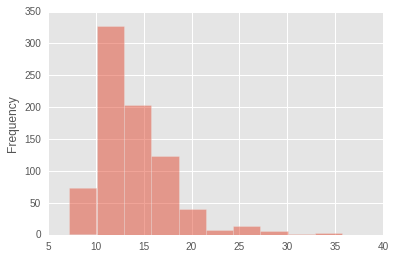

In [43]:
df['taxi_out'].plot(kind='hist', alpha=0.5)

{'boxes': [<matplotlib.lines.Line2D at 0x7fe93afdcbd0>],
 'caps': [<matplotlib.lines.Line2D at 0x7fe93afecb10>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe93af76e10>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fe93af767d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fe93afdcdd0>,
  <matplotlib.lines.Line2D at 0x7fe93afec4d0>]}

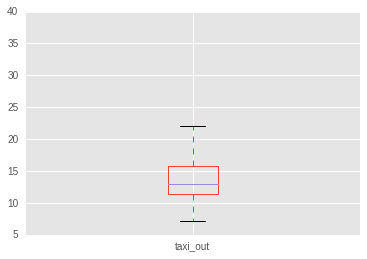

In [44]:
df.boxplot(column='taxi_out')

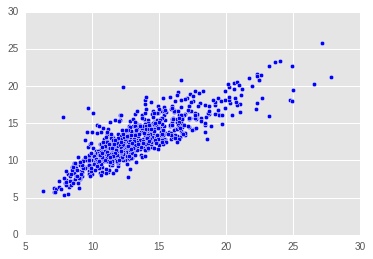

In [48]:
plt.scatter(df['gate_arr_del'], df['gate_dep_del'])
plt.show()

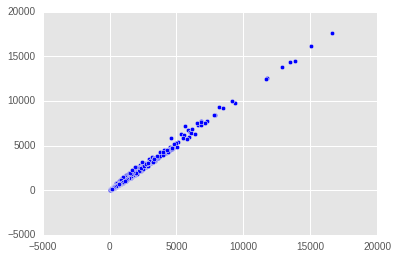

In [50]:
plt.scatter(df['dep_cxl'], df['arr_cxl'])
plt.show()

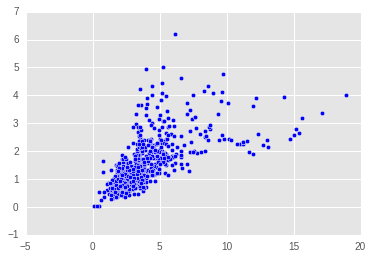

In [51]:
plt.scatter(df['taxi_out_del'], df['taxi_in_del'])
plt.show()

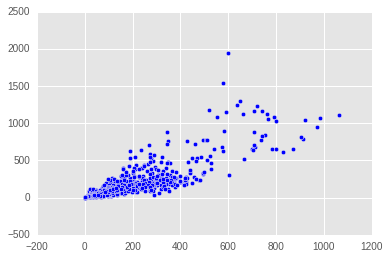

In [52]:
plt.scatter(df['dep_div'], df['arr_div'])
plt.show()

## Part 3: Data Mining

#### Are there any unique values?

In [53]:
##Check for Unique Values 

df.airport.unique()

array(['ABQ', 'ANC', 'ATL', 'AUS', 'BDL', 'BHM', 'BNA', 'BOS', 'BUF',
       'BUR', 'BWI', 'CLE', 'CLT', 'CVG', 'DAL', 'DAY', 'DCA', 'DEN',
       'DFW', 'DTW', 'EWR', 'FLL', 'HNL', 'HOU', 'HPN', 'IAD', 'IAH',
       'IND', 'ISP', 'JAX', 'JFK', 'LAS', 'LAX', 'LGA', 'LGB', 'MCI',
       'MCO', 'MDW', 'MEM', 'MHT', 'MIA', 'MKE', 'MSP', 'MSY', 'OAK',
       'OGG', 'OMA', 'ONT', 'ORD', 'OXR', 'PBI', 'PDX', 'PHL', 'PHX',
       'PIT', 'PSP', 'PVD', 'RDU', 'RFD', 'RSW', 'SAN', 'SAT', 'SDF',
       'SEA', 'SFO', 'SJC', 'SJU', 'SLC', 'SMF', 'SNA', 'STL', 'SWF',
       'TPA', 'TUS'], dtype=object)

#### 3.1 Create Dummy Variables

In [54]:
# create a copy of airport names for use later if we need them.
ap_id = df.airport.values

#create dummy variables for airport codes
apCodes = preprocessing.LabelEncoder()
df.airport = apCodes.fit_transform(df.airport)

In [55]:
df.head()

,airport,year,dep_cxl,arr_cxl,dep_div,arr_div,dep,arr,ot_gate_dep,ot_ap_dep,ot_gate_arr,gate_dep_del,taxi_out,taxi_out_del,ap_dep_del,in_air_del,taxi_in_del,block_del,gate_arr_del
0,0,2004.0,242.0,235.0,71.0,46.0,53971.0,53818.0,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,0,2005.0,221.0,190.0,61.0,33.0,51829.0,51877.0,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,0,2006.0,392.0,329.0,71.0,124.0,49682.0,51199.0,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,0,2007.0,366.0,304.0,107.0,45.0,53255.0,53611.0,0.8005,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,0,2008.0,333.0,300.0,79.0,42.0,49589.0,49512.0,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


In [68]:
df.shape

(799, 19)

#### 3.2 Format the data

In [62]:
taxi = df['taxi_out']
gate = df['gate_dep_del']
year = df['year']
taxDel = df['taxi_out_del']
airDel = df['in_air_del']
print taxi.shape, gate.shape, year.shape, taxDel.shape, airDel.shape

(799,) (799,) (799,) (799,) (799,)


## Part 4: Refine the Data

#### 4.1 Confirm that the dataset has a normal distribution. How can you tell?

In [59]:
normaltest(df)

NormaltestResult(statistic=array([ 526.74257131,  610.35370293,  677.34396372,  672.85698189,
        336.47828022,  540.32889134,  223.19690471,  223.85879996,
        126.79779757,  139.0504605 ,  124.9829939 ,   45.2717115 ,
        295.08863972,  462.20657534,  194.81532975,  142.94812843,
        254.26970344,  110.95544514,  135.43205183]), pvalue=array([  4.16201794e-115,   2.90654736e-133,   8.25328995e-148,
         7.77969961e-147,   8.60339396e-074,   4.66736795e-118,
         3.41513560e-049,   2.45289651e-049,   2.92555386e-028,
         6.39110789e-031,   7.24916038e-028,   1.47697368e-010,
         8.36211330e-065,   4.29652570e-101,   4.97036921e-043,
         9.10349823e-032,   6.10991884e-056,   8.05992905e-025,
         3.90214685e-030]))

In [60]:
df_normalized = preprocessing.normalize(df, norm='l2')

#### 4.2 Find correlations in the data

In [64]:
# conduct correlations

pearsonr(taxi, airDel)

(0.61186977980251467, 3.1046710680743682e-83)

In [65]:
pearsonr(year, airDel)

(-0.33444156049843121, 2.4780695834840307e-22)

In [66]:
pearsonr(gate, airDel)

(0.32808369913127883, 1.6639233589008552e-21)

In [67]:
pearsonr(taxDel, airDel)

(0.64291261021692325, 2.2139198719479529e-94)

#### 4.3 What is the p-value? What does this mean?

The p-value is our measure of the strength of the relationship between x and y. It measures the how likely it is that the null hypothesis is true; in the case of a correlation, how likely it is that two arrays between anaylized are not related.


#### 4.4 What is the value of understanding correlations before PCA?¶

Answer: Highly correlated variables contribute to a common underlying factor in PCA, the principal componant or eigenvector, which helps us further understand patterns in the data.

## Part 5: Perform a PCA and Present Findings

#### 5.1 Define your "X" and "Y" variables

In [95]:
x = df.ix[:,1:18].values
y = df.ix[:,0].values

#### 5.2 Standardize the x values

In [96]:
xStand = preprocessing.StandardScaler().fit_transform(x)

#### 5.3 Create the covariance matrix

In [97]:
covMat = np.cov(xStand.T)
eigenValues, eigenVectors = np.linalg.eig(covMat)

#### Check the Eigenvalues and Eigenvectors

In [98]:
print(eigenValues)

[  8.82790315e+00   3.68243378e+00   1.44550793e+00   9.27383505e-01
   5.72994712e-01   4.25010947e-01   3.54850048e-01   2.45571026e-01
   1.68165397e-01   1.42045655e-01   1.11222422e-01   6.15835274e-02
   4.97070292e-02   4.19080881e-03   1.68969604e-04   1.61133911e-03
   9.53012313e-04]


In [99]:
print(eigenVectors)

[[  4.20731157e-02  -2.46112360e-02  -6.12664471e-01   6.23673311e-01
    1.12088877e-01   2.00783003e-01   3.81901737e-01   4.17865972e-02
   -6.19174926e-03  -9.58868279e-02  -1.37323688e-01  -2.45677939e-02
   -4.91941471e-02   4.04515645e-02   2.22703954e-03  -7.40809298e-03
   -3.86956711e-03]
 [ -2.82688887e-01  -1.58012546e-01  -1.25906384e-01  -2.17006357e-01
   -8.72768481e-02   5.39869133e-01  -7.10602289e-02  -9.51238795e-02
    1.31751867e-01   6.56453807e-02  -6.33953178e-02   3.50850679e-02
    4.90643189e-02   1.32367406e-01   7.54816882e-03   6.86589069e-01
   -2.63259016e-02]
 [ -2.81661403e-01  -1.69955136e-01  -1.31807841e-01  -2.22568847e-01
   -8.60757058e-02   5.07960345e-01  -5.20914646e-02  -1.22795986e-01
    1.22036330e-01   4.66279005e-02  -7.56678432e-02   1.04212996e-02
    1.08010966e-01  -1.54085176e-01  -6.32573482e-03  -6.94824590e-01
    2.27091233e-02]
 [ -2.67407764e-01  -2.57254843e-01  -1.35084391e-01  -1.02948036e-01
    5.20702432e-02  -2.2563501

#### 5.4 Print the Eigenpairs

In [100]:
eigenPairs = [(np.abs(eigenValues[i]), eigenVectors[:,i]) for i in range(len(eigenValues))]
eigenPairs.sort()
eigenPairs.reverse()
for i in eigenPairs:
    print(i[0])

8.82790314818
3.68243377799
1.44550793288
0.927383505101
0.572994711899
0.425010947388
0.354850048315
0.245571026428
0.168165396831
0.14204565481
0.111222421949
0.0615835273714
0.0497070291609
0.00419080881418
0.00161133910758
0.000953012313031
0.000168969603539


#### 5.5 Calculate the explained variance

In [101]:
totalEigen = sum(eigenValues)
varExpl = [(i / totalEigen)*100 for i in sorted(eigenValues, reverse=True)]

In [102]:
print(varExpl)

[51.863849755198288, 21.634264557435863, 8.4923458031432659, 5.4483695580537752, 3.3663386593185565, 2.4969354046631049, 2.0847407682791821, 1.4427275203517644, 0.98797015880757333, 0.83451691480932233, 0.65343070540396331, 0.36180265657336558, 0.29202833888240165, 0.024620963216608463, 0.0094666024283724531, 0.0055989385687911248, 0.00099269486581600843]


In [103]:
cvarex = np.cumsum(varExpl)

In [104]:
print(cvarex)

[  51.86384976   73.49811431   81.99046012   87.43882967   90.80516833
   93.30210374   95.38684451   96.82957203   97.81754219   98.6520591
   99.30548981   99.66729246   99.9593208    99.98394176   99.99340837
   99.99900731  100.        ]


#### 5.6 Conduct the PCA

In [105]:
PCA_A = PCA(n_components=3)
Y = PCA_A.fit_transform(xStand)

In [106]:
print Y

[[ 2.46084353 -0.41802129 -1.06666897]
 [ 2.8057173  -0.79785039 -0.87229044]
 [ 2.32607075 -0.2357234  -0.42322298]
 ..., 
 [ 3.63687257 -1.47087083  0.16484895]
 [ 2.90942893 -0.19347476  0.79391402]
 [ 2.4358858   0.59082792  1.28439566]]


#### 5.7 Create a dataframe from the PCA results

In [117]:
Ydf = pd.DataFrame(Y, columns=["PC1", "PC2", "PC3"])

Now, create a new dataframe that uses the airport and year from the original set and join the PCA results with it to form a new set

In [118]:
airports2 = df[['airport', 'year']]
airports2.head()

,airport,year
0,0,2004.0
1,0,2005.0
2,0,2006.0
3,0,2007.0
4,0,2008.0


In [119]:
df_ap_id = pd.DataFrame(ap_id)
airports2 = pd.concat([airports2, df_ap_id], axis=1)
del airports2['airport']
airports2.columns = ['year','airport']
airports2.head(100)

,year,airport
0,2004.0,ABQ
1,2005.0,ABQ
2,2006.0,ABQ
3,2007.0,ABQ
4,2008.0,ABQ
5,2009.0,ABQ
6,2010.0,ABQ
7,2011.0,ABQ
8,2012.0,ABQ
9,2013.0,ABQ


In [120]:
airport_pca = airports2.join(Ydf, on=None, how='left')
airport_pca.head()

,year,airport,PC1,PC2,PC3
0,2004.0,ABQ,2.460844,-0.418021,-1.066669
1,2005.0,ABQ,2.805717,-0.797850,-0.872290
2,2006.0,ABQ,2.326071,-0.235723,-0.423223
3,2007.0,ABQ,1.954575,-0.071516,-0.375289
4,2008.0,ABQ,2.449075,-0.464617,-0.131609


#### 5.8 Graph the results to a new feature space

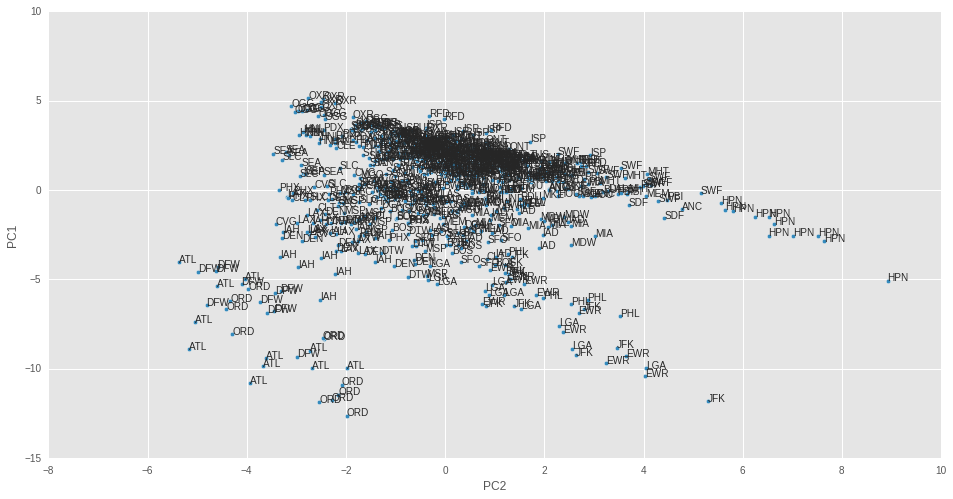

In [121]:
graph = airport_pca.plot(kind='scatter', x='PC2', y='PC1', figsize=(16,8))

for i, airport in enumerate(airport_pca['airport']):
    graph.annotate(airport, (airport_pca.iloc[i].PC2, airport_pca.iloc[i].PC1))

#### 5.9 Write an analysis plan of your findings

## Bonus:

#### 2. Create visualization of your data using the ggplot features of matplotlib

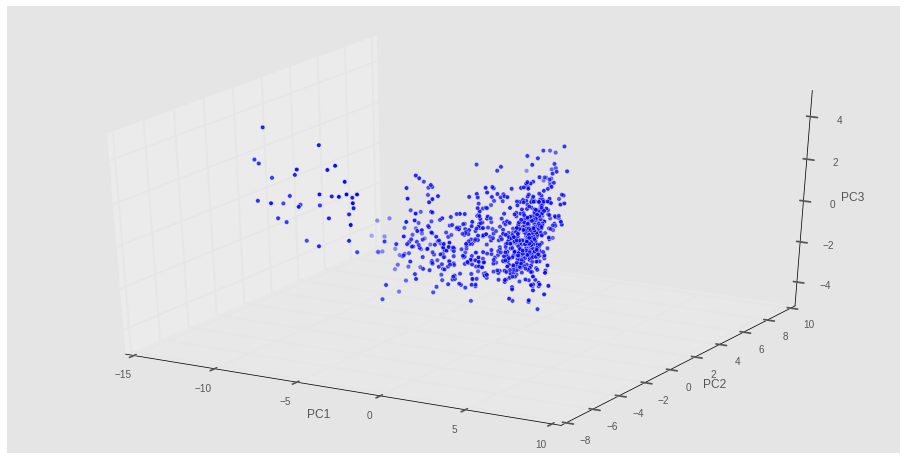

In [131]:
threedee = plt.figure(figsize=(16,8)).gca(projection='3d')
threedee.scatter(airport_pca.PC1, airport_pca.PC2, airport_pca.PC3)
threedee.set_xlabel('PC1')
threedee.set_ylabel('PC2')
threedee.set_zlabel('PC3')

# I tried to extend the labeling to 3D but apparently that doesn't work. I found an algorithm to handle it
# here: http://stackoverflow.com/questions/10374930/matplotlib-annotating-a-3d-scatter-plot
# But decided really understanding it is beyond my capability this week.

# for i, airport in enumerate(airport_pca['airport']):
#    threedee.annotate(airport, (airport_pca.iloc[i].PC1, airport_pca.iloc[i].PC2, airport_pca.iloc[i].PC3))
plt.show()